# Helper Notebook to load and use a pretrained model

In [5]:
import codecs
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

from models.QRN18 import QRN18
from dataset import QaidaDataset
from utils.framework import calculate_accuracy, test_loop
from utils.transform import get_transform

### Plotting utils

In [6]:
def plot_image_and_pred(im, lbl, pred, ligatures_map, num_values, print_ligature_map):
    """
    Print ligature image and top k predictions (as a bar chart).
    im: RGB image as 3d numpy array
    lbl: int correct label
    pred: Prediction scores for all classes
    ligatures_map: imdex to ligature map are an array
    num_values: number of top prediction values to be shown in the bar chart
    print_ligature_map = boolean indicating weather to print the ligatures for top k predictions
    """
    
    max_idx = np.argsort(pred)[::-1]
    max_values = pred[max_idx]
    
    fig= plt.figure(figsize=(10,5))
    ax= fig.add_subplot(1,2,1)
    ax.imshow(im)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Sample image")
    
    ax = fig.add_subplot(1,2,2)
    bars = ax.bar(range(num_values), height=max_values[:num_values])
    ax.set_xticks(range(num_values))
    ax.set_xticklabels(max_idx[:num_values])
    ax.set_xlabel("Class labels")
    ax.set_ylabel("Un-normalised prediction score")
    ax.set_title("Top {} class predictions \n Correct in green".format(num_values))
    
    correct_bar_idx = np.where(max_idx == lbl)[0][0]
    if correct_bar_idx < num_values:
        bars[correct_bar_idx].set_color('g')
    
    plt.show()
        
    if print_ligature_map:
        print ("Class to ligature map:")
        for idx in max_idx[:num_values]:
            print("Class index {} -> ligature {}".format(idx, ligatures_map[idx].strip()))


def predict_and_plot_image(img, lbl, model, ligatures_map, shift=0, shift_axis=2, num_pred_values=5, 
                          print_ligature_map = False):
    
    im = img.roll(shift, dims = shift_axis) if shift else img
    
    # get prediction
    pred = model(im[np.newaxis, : ])
    pred = pred.detach().numpy()[0]
    pred_class = np.argmax(pred)
    
    rgb_im = np.transpose(im, [1,2,0])

    print("{}\nPrediction {}\nGround truth {}".format("Correct" if pred_class == lbl else "Wrong",
                                                      pred_class, 
                                                      lbl))
    
    plot_image_and_pred(rgb_im, lbl, pred, ligatures_map, num_pred_values, print_ligature_map)

### Create Model instange

In [7]:
target_classes = 18569
fc_neurons = []
device = "cuda"
batch_size = 128
pre_trained_model_path = "../data/qaida_v1.bin"

In [8]:
model = QRN18(pre_trained=False,
              backbone="QRN18_18569", 
              num_classes=target_classes, 
              model_config="../data/config/model.json", 
              fc_neurons=[])

### Load weights and prepare model

In [9]:
model.load_state_dict(torch.load(pre_trained_model_path))
model.eval()
model.double()
print("Model loaded")

Model loaded


### Load Ligature Map

In [10]:
with codecs.open('../data/ligatures_map', encoding='UTF-16LE') as ligature_file:
    ligatures_map = ligature_file.readlines()

### Load example image

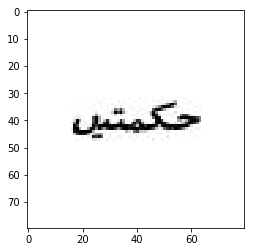

In [12]:
def rgb_to_tensor(rgb_img):
    img = np.transpose(rgb_img, [2,0,1])
    img = torch.from_numpy(img.astype(np.float64))
    return img


im = plt.imread("../data/example_imgs/17559.jpg")
im = im.astype(np.float64) / 255.
img_tensor = rgb_to_tensor(im)
lbl = 17559

plt.imshow(im)

### Get prediction


In [13]:
pred = model(img_tensor[np.newaxis, : ])

# convert predictions from pytorch tensor to numpy array
pred = pred.detach().numpy()[0]

# get class with max score
pred_class = np.argmax(pred)

# get ligature values of predicted class from ligature_map
ligature = ligatures_map[pred_class]

print("Predicted class: {}, ligature: {}".format(pred_class, ligature))

Predicted class: 17559, ligature: حکمتیں



# Visualization of top k classes

Correct
Prediction 17559
Ground truth 17559


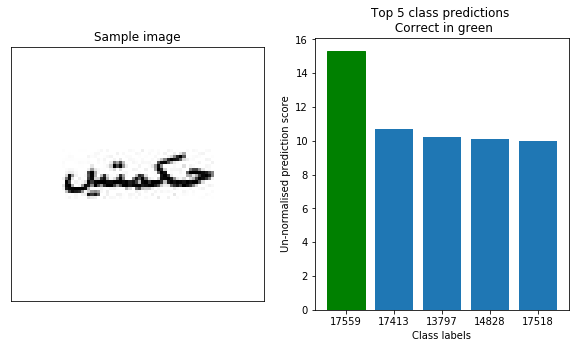

Class to ligature map:
Class index 17559 -> ligature حکمتیں
Class index 17413 -> ligature چمکتیں
Class index 13797 -> ligature حمتیں
Class index 14828 -> ligature حکمتی
Class index 17518 -> ligature جھکتیں


In [14]:
predict_and_plot_image(img_tensor, lbl, model, ligatures_map, shift=0, shift_axis=2, num_pred_values=5, print_ligature_map=True)

# Inspect the predictions with Ipython Wigit

In [15]:
from ipywidgets import interactive
from ipywidgets import fixed

interactive_plot = interactive(predict_and_plot_image, 
                               shift=(-25, 25),
                               shift_axis = [('y-axis', 1), ('x-axis', 2)],
                               num_pred_values = (5, 20),
                               img = fixed(img_tensor),
                               lbl= fixed(lbl),
                               ligatures_map = fixed(ligatures_map),
                               model = fixed(model))

output = interactive_plot.children[-1]
output.layout.height = '600px'
interactive_plot

interactive(children=(IntSlider(value=0, description='shift', max=25, min=-25), Dropdown(description='shift_ax…